In [1]:
from pseudo.minimize import minimize
from pseudo.problems import rosenbrock, rosen_boundaries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from concurrent.futures import ThreadPoolExecutor

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.problems import get_problem
from pymoo import optimize
from pymoo.core.callback import Callback
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination import get_termination

from tqdm import tqdm

### Defining some helper functions

In [9]:
class SavePopulationCallback(Callback):
    def __init__(self):
        super().__init__()
        self.data = []

    def notify(self, algorithm):
        best_idx = np.argmin(algorithm.pop.get("F"))
        best_x = np.float32(algorithm.pop.get("X")[best_idx])
        best_f = np.float32(algorithm.pop.get("F")[best_idx])
        self.data.append((best_x, best_f))


def repeat(n, func, *args, **kwargs):
    """Repeat a function n times.
    """
    with ThreadPoolExecutor() as executor:
        result = list(executor.map(lambda _: func(*args, **kwargs), range(n)))
        return np.asarray(result)

In [5]:
#@title Experiment helper functions

def pseudo(NP, F, Cr, y, dims, max_iter):
  """Run a pseudo optimization algorithm for the rosenbrock function 30 times.
  """
  results = repeat(30, minimize, fobj=rosenbrock, boundaries=rosen_boundaries(dims), NP=NP, F=F, Cr=Cr, y=y, max_iter=max_iter)
  return np.array([list(result) for result in tqdm(results)], dtype=[('best_x', float, (dims,)), ('fitness', float)])

def rosen_pseudo(X, NP, y, dims, max_iter=100):
  f1, f2, f3, Cr = X
  F = np.array([f1, f2, f3])
  results = repeat(30, minimize, fobj=rosenbrock, boundaries=rosen_boundaries(dims), NP=NP, F=F, Cr=Cr, y=y, max_iter=max_iter)
  return np.min(np.array([list(result) for result in results], dtype=[('best_x', float, (dims,)), ('fitness', float)])["fitness"].mean(axis=0))

def tune(minimizer, *args, **kwargs):
  fobj = lambda x: minimizer(x, *args, **kwargs)
  result = minimize(fobj, [[0, 0.7]]*4, 10, np.array([0.2, 0.2, 0.2]), 0.5, 1, 30)
  return np.array(list(tqdm(result)), dtype=[('best_x', float, (4,)), ('fitness', float)])

def pymoo_de(NP, Cr, x, y, dims, max_iter=100):
  """Run a pymoo DE algorithm for the rosenbrock function 30 times.
  """
  problem = get_problem("rosenbrock", n_var=dims)

  pymoo_de = DE(
  pop_size=NP,
  sampling=LHS(),
  variant=f"DE/{x}/{y}/bin",
  CR=Cr,
  dither="vector",
  jitter=False)

  termination = get_termination("n_gen", max_iter)

  exp = []
  for _ in tqdm(range(30)):
    callback = SavePopulationCallback()
    res = optimize.minimize(problem,
                  pymoo_de,
                  termination=termination,
                  seed=np.random.randint(0, 10000),
                  callback=callback)
    exp.append(callback.data)

  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])

def pso(NP, w, c1, c2, dims, max_iter=100):
  """Run a pymoo PSO algorithm for the rosenbrock function 30 times.
  """
  problem = get_problem("rosenbrock", n_var=dims)

  pymoo_pso = PSO(
      pop_size= NP,
      w = w,
      c1 = c1,
      c2 = c2
  )

  termination = get_termination("n_gen", max_iter)

  exp = []
  for _ in tqdm(range(30)):
    callback = SavePopulationCallback()
    res = optimize.minimize(problem,
                  pymoo_pso,
                  termination=termination,
                  seed=np.random.randint(0, 10000),
                  callback=callback)
    exp.append(callback.data)

  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])


### 10 dims

In [10]:
#@title running for 10 dimensions.

strats = ["best", "rand"]
y = 2
NP = 100
Cr = 0.5
F = np.array([0.2, 0.2, 0.2])
dims = 10
gens = 100

pymoo_10 = {}

for x in strats:
    pymoo_10[x] = pymoo_de(NP, Cr, x, y, dims, gens)

pso_10 = pso(NP, F[0], F[1], F[2], dims, gens)

pseudo_10 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:08<00:00,  3.39it/s]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:12<00:00,  2.48it/s]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:01<00:00, 16.04it/s]


#### Finetuning

In [11]:
#@title finetunning - this takes some time

tuner = tune(rosen_pseudo, 10, y, dims, gens)

30it [01:53,  3.78s/it]


In [12]:
f1, f2, f3, Cr = tuner["best_x"][np.argmin(tuner["fitness"])]
F = np.array([f1, f2, f3])

tuned_10 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:01<00:00, 15.47it/s]


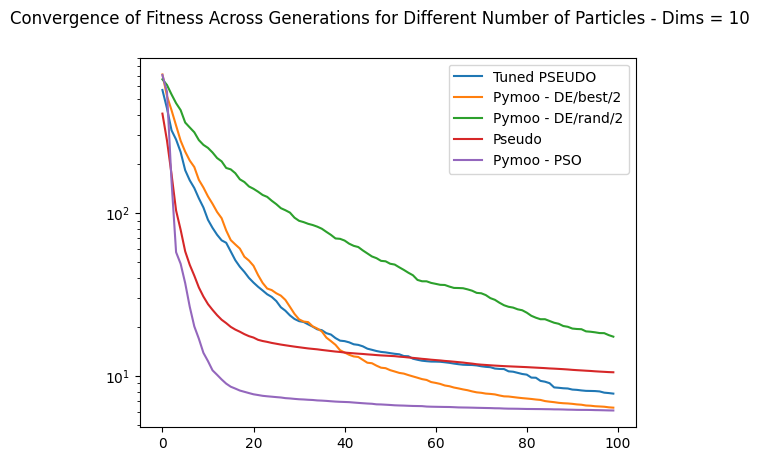

In [13]:
plt.plot(tuned_10["fitness"].mean(axis=0), label="Tuned PSEUDO")

X = ["best", "rand"]

for x in strats:
    plt.plot(pymoo_10[x]["fitness"].mean(axis=0), label=f"Pymoo - DE/{x}/2")

plt.plot(pseudo_10["fitness"].mean(axis=0), label=f"Pseudo")

plt.plot(pso_10["fitness"].mean(axis=0), label=f"Pymoo - PSO")


plt.suptitle("Convergence of Fitness Across Generations for Different Number of Particles - Dims = 10")

plt.legend()
plt.yscale("log")
plt.show()

/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/3206630890.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels= labels)


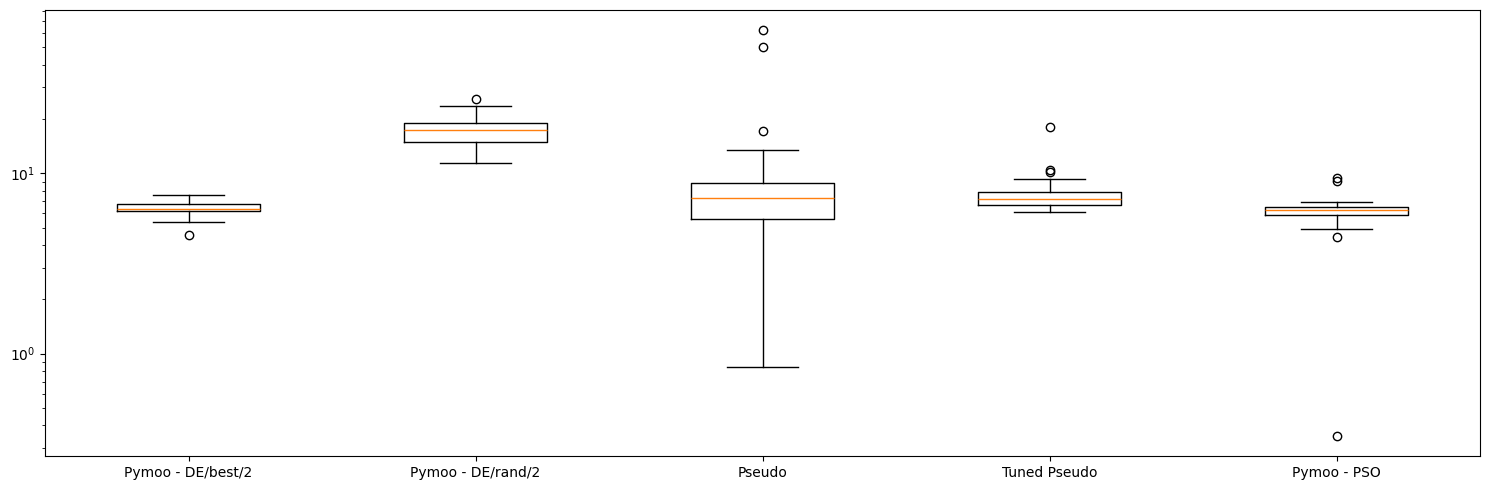

In [14]:
fig = plt.figure(figsize=(15, 5))

data = [pymoo_10[strat]["fitness"][:, 99] for strat in strats] + [pseudo_10["fitness"][:, 99]] + [tuned_10['fitness'][:, 99]] + [pso_10['fitness'][:, 99]]
labels = [f"Pymoo - DE/{strat}/2" for strat in strats] + ["Pseudo"] + ["Tuned Pseudo"] + ["Pymoo - PSO"]

plt.boxplot(data, labels= labels)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to fit the main title
plt.show()

### 30 dims

In [38]:
#@title runing for 30 dims
strats = ["best", "rand"]
y = 2
NP = 100
Cr = 0.5
F = np.array([0.2, 0.2, 0.2])
dims = 30
gens = 100

pymoo_30 = {}

for x in strats:
    pymoo_30[x] = pymoo_de(NP, Cr, x, y, dims, gens)

pso_30 = pso(NP, F[0], F[1], F[2], dims, gens)

pseudo_30 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:09<00:00,  3.03it/s]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:18<00:00,  1.59it/s]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:01<00:00, 15.31it/s]


In [16]:
#@title finetunning - this takes some time

tuner_30 = tune(rosen_pseudo, 10, y, dims, gens)

30it [01:59,  3.98s/it]


In [39]:
f1, f2, f3, Cr = tuner_30["best_x"][np.argmin(tuner_30["fitness"])]
F = np.array([f1, f2, f3])

tuned_30 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:01<00:00, 15.10it/s]


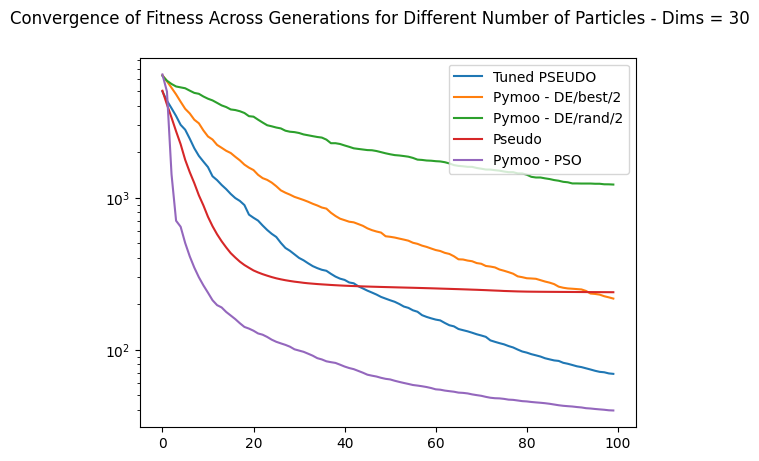

In [40]:
plt.plot(tuned_30["fitness"].mean(axis=0), label="Tuned PSEUDO")

X = ["best", "rand"]

for x in strats:
    plt.plot(pymoo_30[x]["fitness"].mean(axis=0), label=f"Pymoo - DE/{x}/2")

plt.plot(pseudo_30["fitness"].mean(axis=0), label=f"Pseudo")

plt.plot(pso_30["fitness"].mean(axis=0), label=f"Pymoo - PSO")


plt.suptitle("Convergence of Fitness Across Generations for Different Number of Particles - Dims = 30")

plt.legend()
plt.yscale("log")
plt.show()

/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/3573871495.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels= labels)


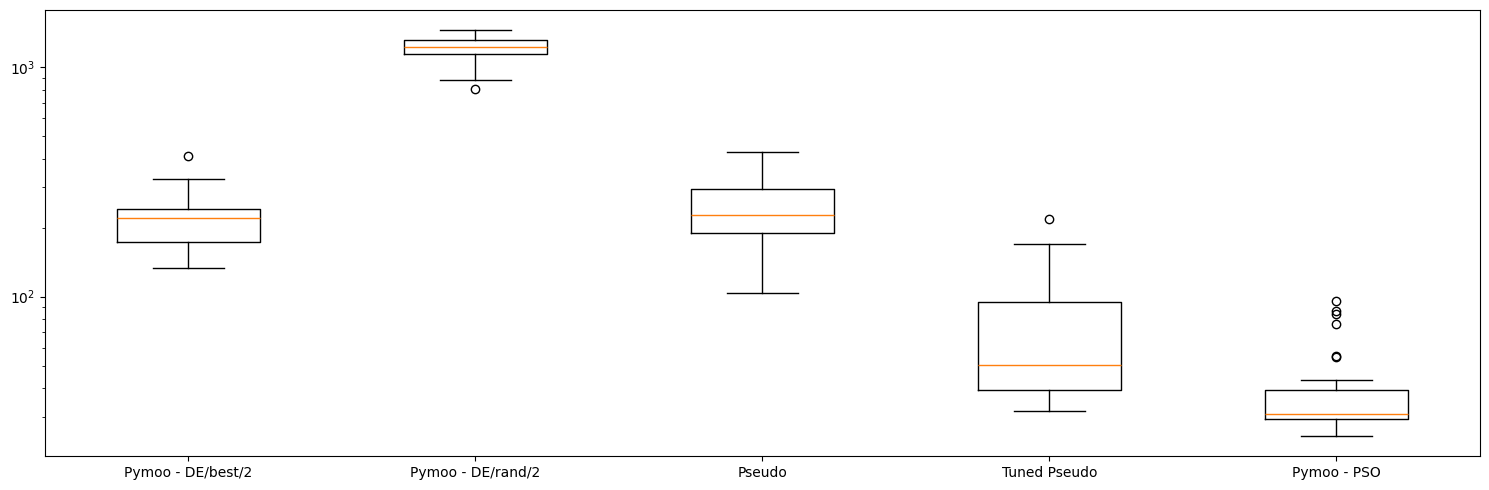

In [41]:
fig = plt.figure(figsize=(15, 5))

data = [pymoo_30[strat]["fitness"][:, 99] for strat in strats] + [pseudo_30["fitness"][:, 99]] + [tuned_30['fitness'][:, 99]] + [pso_30['fitness'][:, 99]]
labels = [f"Pymoo - DE/{strat}/2" for strat in strats] + ["Pseudo"] + ["Tuned Pseudo"] + ["Pymoo - PSO"]

plt.boxplot(data, labels= labels)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to fit the main title
plt.show()

### 50 dims

In [20]:
#@title runing for 50 dims
strats = ["best", "rand"]
y = 2
NP = 100
Cr = 0.5
F = np.array([0.2, 0.2, 0.2])
dims = 50
gens = 100

pymoo_50 = {}

for x in strats:
    pymoo_50[x] = pymoo_de(NP, Cr, x, y, dims, gens)

pso_50 = pso(NP, F[0], F[1], F[2], dims, gens)

pseudo_50 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:10<00:00,  2.79it/s]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:22<00:00,  1.32it/s]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:02<00:00, 13.18it/s]


In [21]:
#@title finetunning - this takes some time

tuner_50 = tune(rosen_pseudo, 10, y, dims, gens)

30it [02:05,  4.17s/it]


In [31]:
f1, f2, f3, Cr = tuner_50["best_x"][np.argmin(tuner_50["fitness"])]
F = np.array([f1, f2, f3])

tuned_50 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:02<00:00, 12.28it/s]


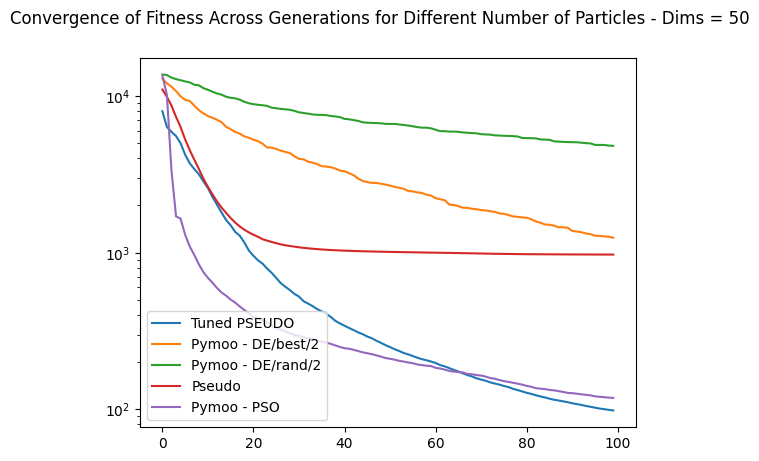

In [32]:
plt.plot(tuned_50["fitness"].mean(axis=0), label="Tuned PSEUDO")

X = ["best", "rand"]

for x in strats:
    plt.plot(pymoo_50[x]["fitness"].mean(axis=0), label=f"Pymoo - DE/{x}/2")

plt.plot(pseudo_50["fitness"].mean(axis=0), label=f"Pseudo")

plt.plot(pso_50["fitness"].mean(axis=0), label=f"Pymoo - PSO")


plt.suptitle("Convergence of Fitness Across Generations for Different Number of Particles - Dims = 50")

plt.legend()
plt.yscale("log")
plt.show()

/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/3289115997.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels= labels)


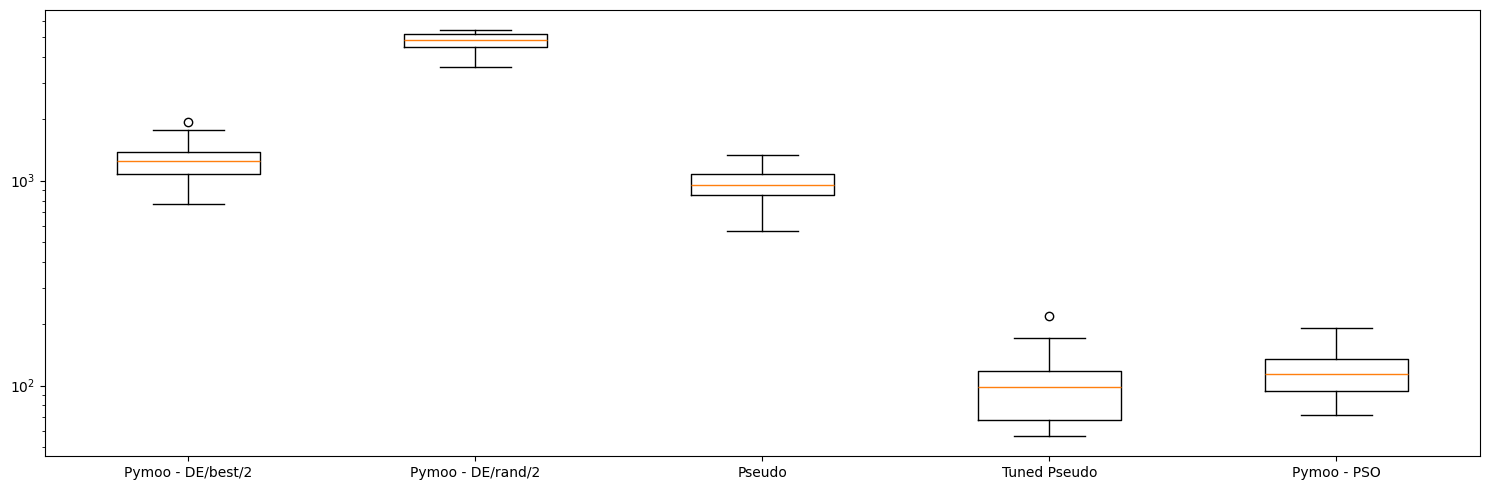

In [33]:
fig = plt.figure(figsize=(15, 5))

data = [pymoo_50[strat]["fitness"][:, 99] for strat in strats] + [pseudo_50["fitness"][:, 99]] + [tuned_50['fitness'][:, 99]] + [pso_50['fitness'][:, 99]]
labels = [f"Pymoo - DE/{strat}/2" for strat in strats] + ["Pseudo"] + ["Tuned Pseudo"] + ["Pymoo - PSO"]

plt.boxplot(data, labels= labels)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to fit the main title
plt.show()

### 75 dims

In [42]:
#@title runing for 50 dims
strats = ["best", "rand"]
y = 2
NP = 100
Cr = 0.5
F = np.array([0.2, 0.2, 0.2])
dims = 75
gens = 100

pymoo_75 = {}

for x in strats:
    pymoo_75[x] = pymoo_de(NP, Cr, x, y, dims, gens)

pso_75 = pso(NP, F[0], F[1], F[2], dims, gens)

pseudo_75 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:13<00:00,  2.29it/s]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:36<00:00,  1.20s/it]
/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/1447787194.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array(exp, dtype=[('best_x', float, (dims,)), ('fitness', float)])
100%|██████████| 30/30 [00:02<00:00, 11.79it/s]


In [43]:
#@title finetunning - this takes some time

tuner_75 = tune(rosen_pseudo, 30, y, dims, gens)

30it [04:27,  8.92s/it]


In [44]:
f1, f2, f3, Cr = tuner_75["best_x"][np.argmin(tuner_75["fitness"])]
F = np.array([f1, f2, f3])

tuned_75 = pseudo(NP, F, Cr, y, dims, gens)

100%|██████████| 30/30 [00:02<00:00, 12.19it/s]


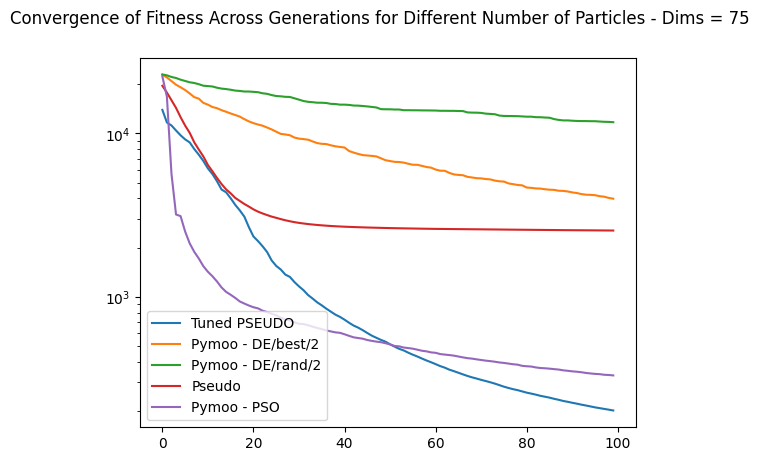

In [45]:
plt.plot(tuned_75["fitness"].mean(axis=0), label="Tuned PSEUDO")

X = ["best", "rand"]

for x in strats:
    plt.plot(pymoo_75[x]["fitness"].mean(axis=0), label=f"Pymoo - DE/{x}/2")

plt.plot(pseudo_75["fitness"].mean(axis=0), label=f"Pseudo")

plt.plot(pso_75["fitness"].mean(axis=0), label=f"Pymoo - PSO")


plt.suptitle("Convergence of Fitness Across Generations for Different Number of Particles - Dims = 75")

plt.legend()
plt.yscale("log")
plt.show()

/var/folders/17/fvcftbh93gv7xkd67fy2ddkr0000gn/T/ipykernel_47762/3520749815.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels= labels)


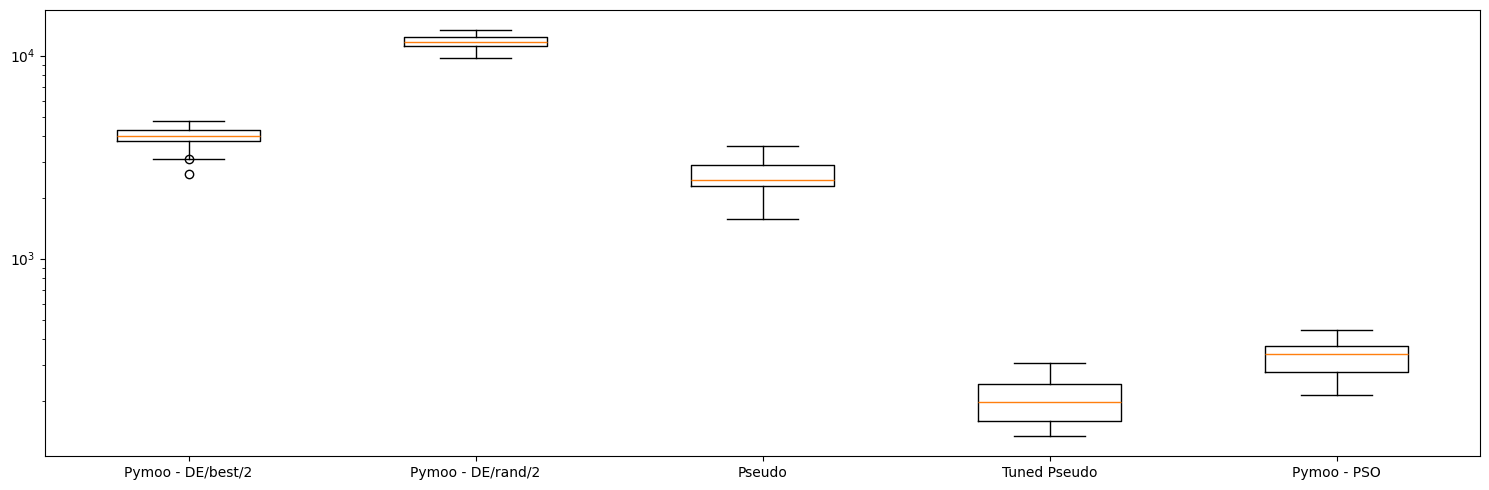

In [46]:
fig = plt.figure(figsize=(15, 5))

data = [pymoo_75[strat]["fitness"][:, 99] for strat in strats] + [pseudo_75["fitness"][:, 99]] + [tuned_75['fitness'][:, 99]] + [pso_75['fitness'][:, 99]]
labels = [f"Pymoo - DE/{strat}/2" for strat in strats] + ["Pseudo"] + ["Tuned Pseudo"] + ["Pymoo - PSO"]

plt.boxplot(data, labels= labels)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to fit the main title
plt.show()